## Kaggleのデータセットを用いてモデルを構築する

#### 目的：クラウドファンディングが成功するかを予測するモデルを構築する
#### Kickstarter Projects URL:https://www.kaggle.com/kemical/kickstarter-projects

### 【手順】
#### 1.データ読込
#### 2.データ前処理
- 事前に予測できない項目は、除外する
- 目的変数と説明変数の関係を確認するためのグラフを作成する
- 目的変数を説明するのに有効そうな説明変数を見つける
- 質的変数が扱えない場合は、ダミー変数に置き換える

#### 3.モデル生成
- ロジスティック回帰モデルを利用する
- モデルパラメータ（重み）：$\mathbf{w} = (w_0, w_1, w_2, \dots, w_p)^{\mathrm{T}} $
- モデルへの入力：$\mathbf{x} = (1, x_1, x_2, \dots, x_p)^{\mathrm{T}} $
- 以上の2つが与えられたときのモデルの出力（確率値）：$\hat{Y}(\mathbf{x}; \mathbf{w}) =  f(\mathbf{w}^{\mathrm{T}} \mathbf{x})$
- $f$はシグモイド関数：$f(x) = \frac{1}{1 + \exp(-x)}$

#### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

#### ※利用するデータ
- 「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | ID| 識別ID | - | 不要と思われる為除外 |
|  2 | name |名称 | 欠損あり | ○※文字数を算出して利用 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日時 | - | ○※期間算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測できないため除外 |
| 10 | state |プロジェクトの状態 | - | ○※成功と失敗のみ抽出 |
| 11 | backers |支援者数 | - | 予測できないため除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測できないため除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測できないため除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |


▼ 欠損データ確認
name              4
usd pledged    3797
dtype: int64

▼ 相関係数をヒートマップにして可視化


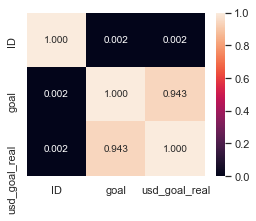

→goalを除外して、usd_goal_realを利用する。

▼ 目的変数 stateの種類（%）


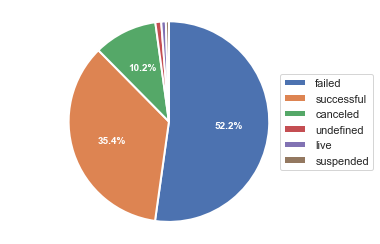

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。

▼ stateが成功または失敗のデータを抽出
failed        197719
successful    133956
Name: state, dtype: int64

▼ 目的変数への影響度を確認する為、成功率の平均値を抽出
baseline= 0.4038772895153388


In [182]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
from collections import Counter

# ============================================================================
# 関数：各データの件数を確認するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート指定
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数（降順）')
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数')
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title('Count by ' + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：各データの成功率を確認するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無
# ============================================================================
def show_successrate_barplot(col_name, w, h, baseline, sort_flg=False):
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False)
        print('\n▼ ' + str(col_name) + '別の成功率（降順）')
    else:
        print('\n▼ ' + str(col_name) + '別の成功率')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('Success rate by ' + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel('Ratio')
    plt.show()

# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

print('\n▼ 欠損データ確認')
print(df.isnull().sum()[df.isnull().sum()>0])

#print("\n▼ 先頭5行")
#print(df.head(5))

# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************

# ------------------------------------------------
# 2-1.項目の選定
# ------------------------------------------------

# 事前に予測できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は事前に予測できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は事前に予測できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は事前に予測できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は事前に予測できない為、除外

# 相関係数をヒートマップにして可視化
print('\n▼ 相関係数をヒートマップにして可視化')
plt.figure(figsize=(4,3))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()
print('→goalを除外して、usd_goal_realを利用する。')

# nameの文字数についても検討する。
df['name_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', '')))

df = df.drop(['ID'], axis=1)               # モデル作成に不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、説明変数にするには難しいと思われるので除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# ------------------------------------------------
# 2-2.目的変数（state）の前処理
# ------------------------------------------------
print('\n▼ 目的変数 stateの種類（%）')
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,
        startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

# stateが成功または失敗のデータを抽出
df = df.query('state in ["successful", "failed"]')

print('\n▼ stateが成功または失敗のデータを抽出')
print(df['state'].value_counts())

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
print('\n▼ 目的変数への影響度を確認する為、成功率の平均値を抽出')
baseline = df['state'].mean()
print('baseline=',baseline)



▼ 期間（日数）の散布図


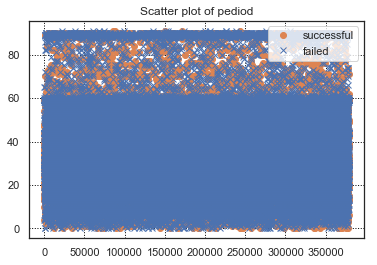


▼ period別の成功数と失敗数


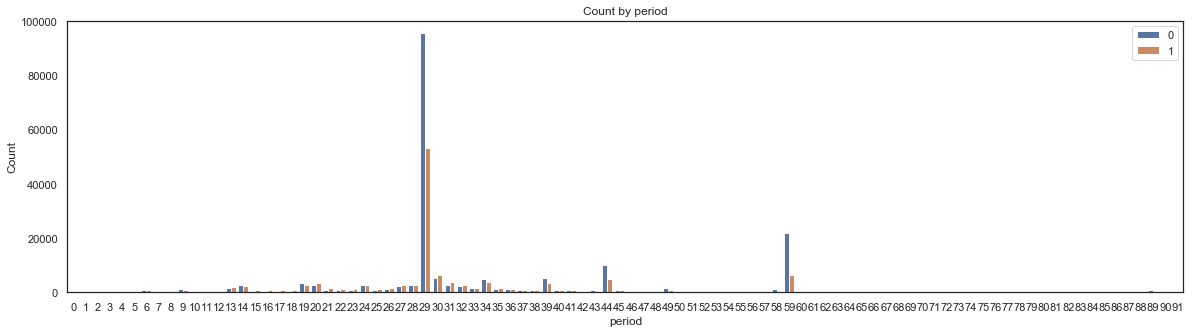

→連続している日数でも、月の節目等で凸凹しているので、ダミー変換することを考える。

▼ period別の成功率


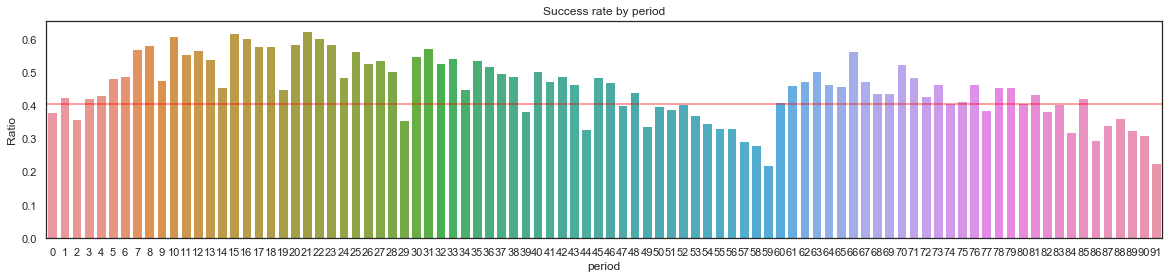

→平均40%の成功率に対して大きく差がでている為、日数が説明変数に何らかの影響を与えていると考えられる。


In [183]:
# ------------------------------------------------
# 2-3.期間(日数)の算出
# ------------------------------------------------
df['period'] = (df['deadline'] - df['launched']).dt.days

print('\n▼ 期間（日数）の散布図')
# 外れ値がないか散布図で確認
plt.figure(figsize=(6,4))
data1 = df.query('state == 1')
data2 = df.query('state == 0')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1.index, data1['period'], 'o', color='C1', label='successful')
plt.plot(data2.index, data2['period'], 'x', color='C0', label='failed')
plt.legend(loc='best')
plt.title('Scatter plot of pediod')
plt.show()

# 日数の分布を確認
show_state_count_plot('period',20,5)
print('→連続している日数でも、月の節目等で凸凹しているので、ダミー変換することを考える。')
show_successrate_barplot("period",20,4,baseline,False)
print('→平均40%の成功率に対して大きく差がでている為、日数が説明変数に何らかの影響を与えていると考えられる。')



▼ 目標金額(usd_goal_real)の散布図


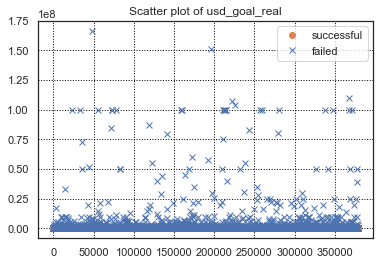


▼ 目標金額(usd_goal_real)の分布


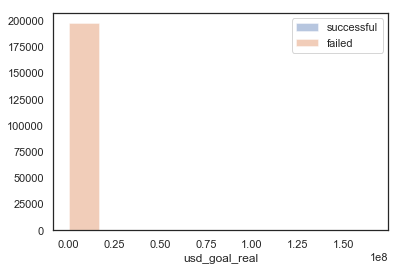

※目標金額の歪度が大きい為、対数変換して分布を修正する
歪度（わいど）： 83.10938853908664

▼ 対数変換した目標金額(usd_goal_real)の分布


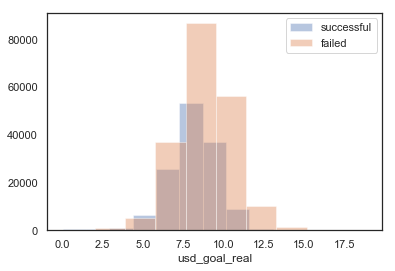

→全体的に目標金額が高くなると失敗しやすくなりそうといえる。


In [184]:
# ------------------------------------------------
# 2-4.目標金額の分布
# ------------------------------------------------
# 外れ値がないか散布図で確認
print('\n▼ 目標金額(usd_goal_real)の散布図')
plt.figure(figsize=(6,4))
data1 = df.query('state == 1')
data2 = df.query('state == 0')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1.index, data1['usd_goal_real'], 'o', color='C1', label='successful')
plt.plot(data2.index, data2['usd_goal_real'], 'x', color='C0', label='failed')
plt.title('Scatter plot of usd_goal_real')
plt.legend(loc='best')
plt.show()

# 目標金額の分布
print('\n▼ 目標金額(usd_goal_real)の分布')
plt.figure(figsize=(6,4))
sns.distplot(df[df['state']==1]['usd_goal_real'],kde=False,rug=False,bins=10,label='successful')
sns.distplot(df[df['state']==0]['usd_goal_real'],kde=False,rug=False,bins=10,label='failed')
plt.legend()
plt.show()

print('※目標金額の歪度が大きい為、対数変換して分布を修正する')
print('歪度（わいど）：',df['usd_goal_real'].skew())

print('\n▼ 対数変換した目標金額(usd_goal_real)の分布')
plt.figure(figsize=(6,4))
sns.distplot(np.log1p(df[df['state']==1]['usd_goal_real']),kde=False,rug=False,bins=10,label='successful')
sns.distplot(np.log1p(df[df['state']==0]['usd_goal_real']),kde=False,rug=False,bins=10,label='failed')
plt.legend()
plt.show()

print('→全体的に目標金額が高くなると失敗しやすくなりそうといえる。')


▼ launched_Month別の成功数と失敗数


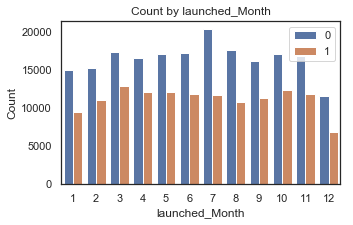


▼ launched_Month別の成功率


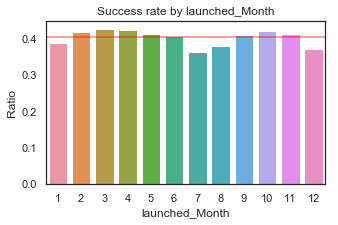

→春と秋あたりに開始すると成功率が高まる。師走は避けたほうが良さそう。

▼ launched_Day別の成功数と失敗数


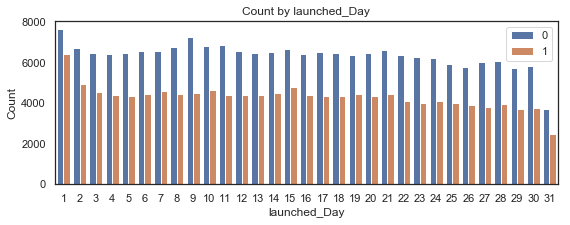


▼ launched_Day別の成功率


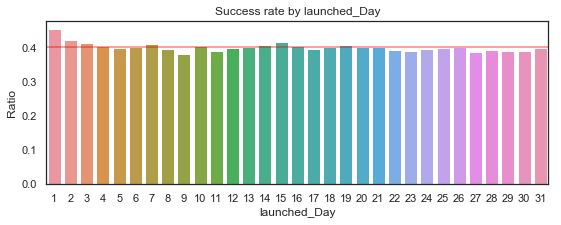

→月の上旬（特に1日開始）の成功率が高い。

▼ launched_Hour別の成功数と失敗数


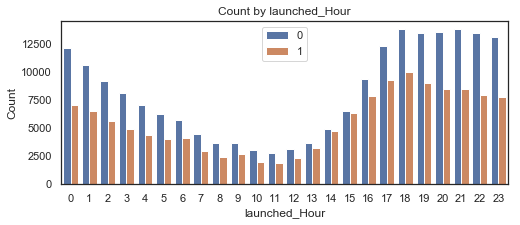


▼ launched_Hour別の成功率


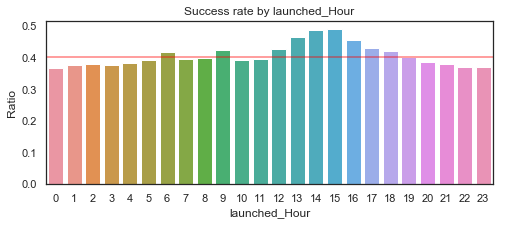

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [185]:
# ------------------------------------------------
# 2-5.開始時期（月、日、時間）の影響度を確認
# ------------------------------------------------
df['launched_Month'] = df['launched'].dt.month
df['launched_Day'] = df['launched'].dt.day
df['launched_Hour'] = df['launched'].dt.hour

show_state_count_plot('launched_Month',5,3)
show_successrate_barplot('launched_Month',5,3,baseline)
print("→春と秋あたりに開始すると成功率が高まる。師走は避けたほうが良さそう。")

show_state_count_plot('launched_Day',9,3)
show_successrate_barplot("launched_Day",9,3,baseline)
print('→月の上旬（特に1日開始）の成功率が高い。')

show_state_count_plot('launched_Hour',8,3)
show_successrate_barplot("launched_Hour",8,3,baseline)
print('→午後2,3時あたりに開始すると成功率が高まるようだ。')



▼ main_category別の成功数と失敗数（降順）


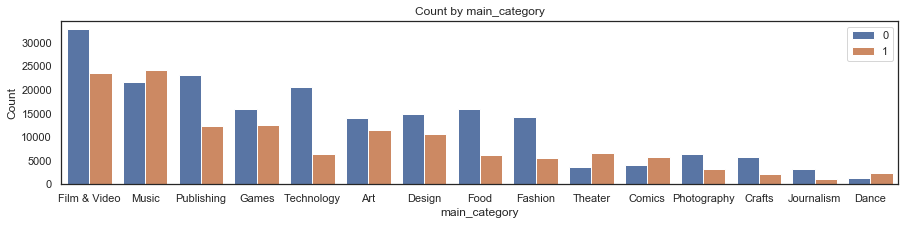


▼ main_category別の成功率（降順）


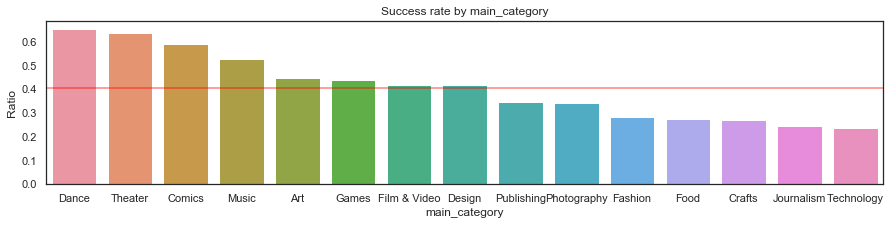


▼ category別の成功数と失敗数（降順）


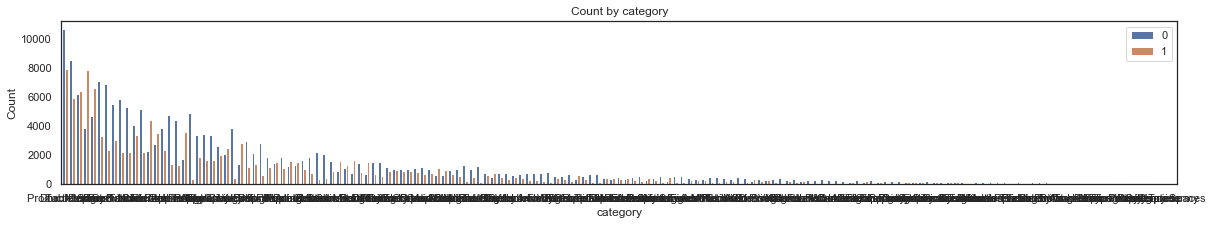


▼ category別の成功率（降順）


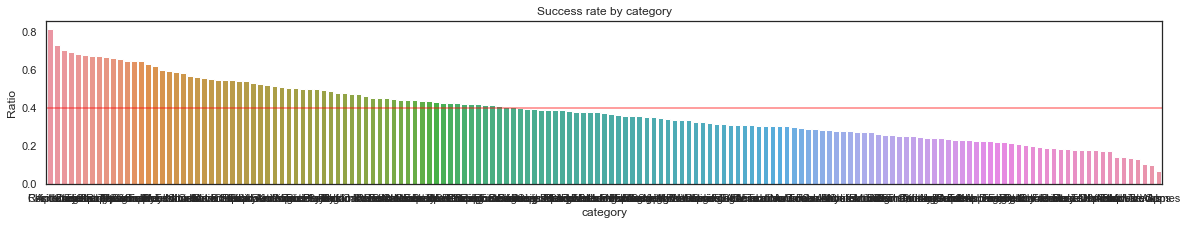

In [186]:
# ------------------------------------------------
# 2-6.カテゴリの影響度を確認
# ------------------------------------------------
show_state_count_plot('main_category',15,3, True)
show_successrate_barplot('main_category',15,3, baseline,True)

show_state_count_plot('category',20,3, True)
show_successrate_barplot('category',20,3, baseline,True)


▼ country別の成功数と失敗数（降順）


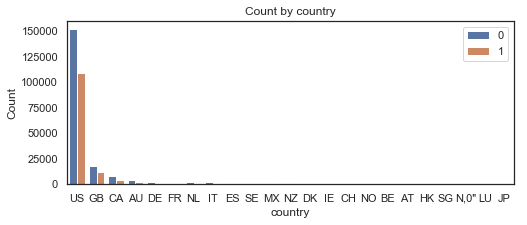


▼ country別の成功率（降順）


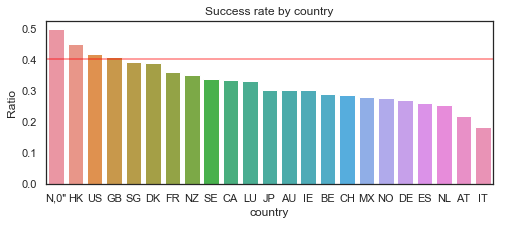

→N,0"について、件数が少ないが、成功率が高いので、悪影響にならないか不安

▼ currency別の成功数と失敗数（降順）


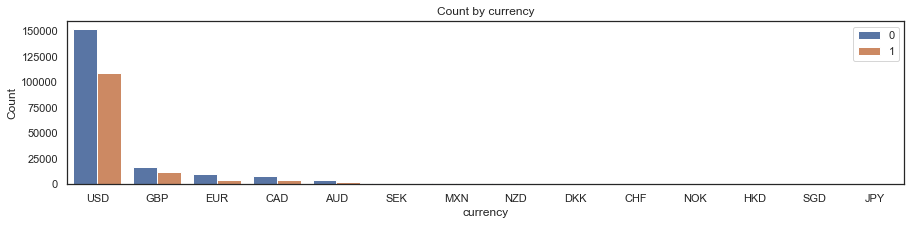


▼ currency別の成功率（降順）


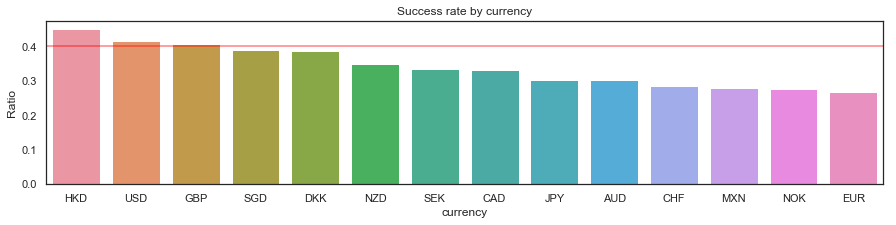

In [187]:
# ------------------------------------------------
# 2-7.countryの影響度を確認
# ------------------------------------------------
show_state_count_plot('country',8,3,True)
show_successrate_barplot('country',8,3,baseline,True)

print('→N,0\"について、件数が少ないが、成功率が高いので、悪影響にならないか不安')
#print("countryのN,0\"の件数")
#print(df["country"].where(df['country'] == 'N,0"').value_counts())
#df = df[(df['country'] != 'N,0"')]

# ------------------------------------------------
# 2-8.currencyの影響度を確認
# ------------------------------------------------
show_state_count_plot('currency',15,3,True)
show_successrate_barplot('currency',15,3,baseline,True)


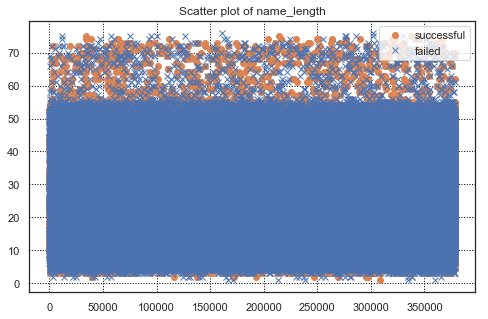


▼ name_length別の成功数と失敗数


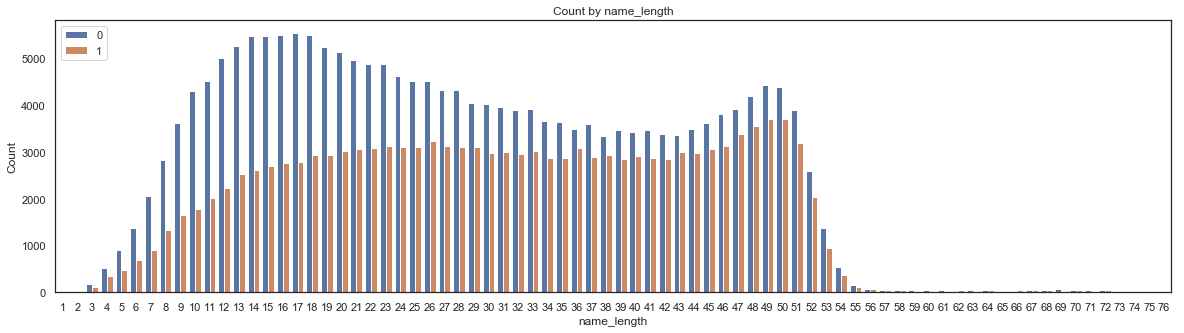


▼ name_length別の成功率


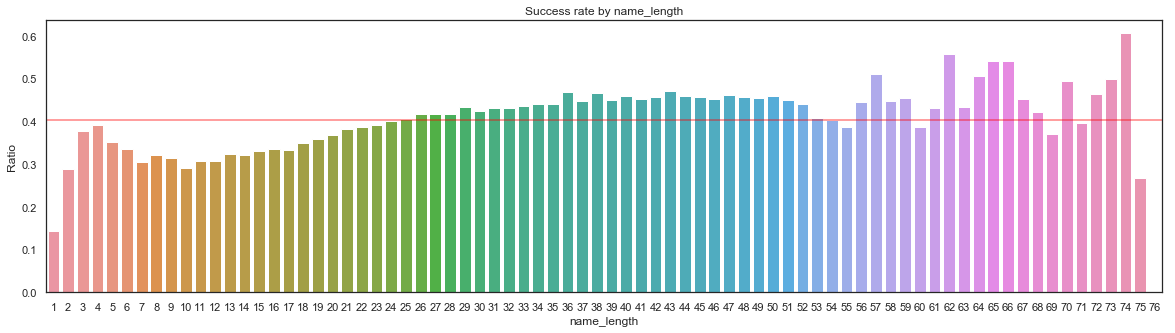

In [188]:
# ------------------------------------------------
# 2-9.name_lengthの影響度を確認
# ------------------------------------------------
# 外れ値がないか散布図で確認
data1 = df.query('state == 1')
data2 = df.query('state == 0')
plt.figure(figsize=(8,5))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1.index, data1['name_length'], 'o', color='C1', label='successful')
plt.plot(data2.index, data2['name_length'], 'x', color='C0', label='failed')
plt.title('Scatter plot of name_length')
plt.legend(loc='best')
plt.show()

show_state_count_plot('name_length',20,5)
show_successrate_barplot('name_length',20,5,baseline)


▼ 相関係数をヒートマップにして可視化


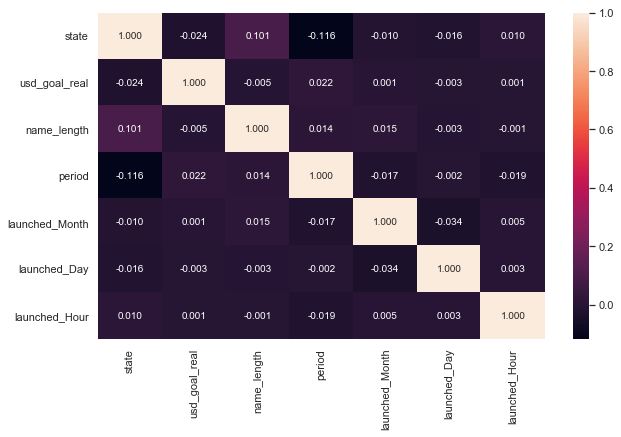

→stateとperiod,name_lengthの相関関係が他より高いことが分かる。


In [189]:
# ------------------------------------------------
# 2-10.相関係数をヒートマップにして可視化
# ------------------------------------------------
print('\n▼ 相関係数をヒートマップにして可視化')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()

print('→stateとperiod,name_lengthの相関関係が他より高いことが分かる。')

In [199]:
# ------------------------------------------------
# 2-10.ダミー変換
# ------------------------------------------------
# 抽出元の不要な項目を削除
df_drop = df.drop(['launched','deadline'], axis=1)

print("\n▼ 説明変数リスト")
print(df_drop.drop('state', axis=1).info())

# one-hot-encoding
df_dummies = pd.get_dummies(df_drop, columns=['main_category','category','country','currency',
                                 'launched_Month','launched_Day','launched_Hour','period'])

# ------------------------------------------------
# 2-11.データ標準化
# ------------------------------------------------
#scaler = StandardScaler()
#df_dummies['usd_goal_real'] = scaler.fit_transform(df_dummies.loc[:, ['usd_goal_real']])
#df_dummies['name_length'] = scaler.fit_transform(df_dummies.loc[:, ['name_length']])


print('\n▼ 説明変数の数')
print(len(df_dummies.drop('state', axis=1).columns))

#print('\n▼ 先頭5行表示')
#print(df_dummies.head(5))

#print("\n▼ 基本統計量")
#print(ddf_dummies.describe())


▼ 説明変数リスト
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 10 columns):
category          331675 non-null object
main_category     331675 non-null object
currency          331675 non-null object
country           331675 non-null object
usd_goal_real     331675 non-null float64
name_length       331675 non-null int64
period            331675 non-null int64
launched_Month    331675 non-null int64
launched_Day      331675 non-null int64
launched_Hour     331675 non-null int64
dtypes: float64(1), int64(5), object(4)
memory usage: 37.8+ MB
None

▼ 説明変数の数
372


372

▼ 回帰係数を表示（絶対値の降順：Top30）
                       feature         weight
0                  name_length  231964.802233
1                 currency_USD    6804.620090
2                   country_US    6797.350234
3   main_category_Film & Video    2102.582410
4          main_category_Music    1949.279159
5                    period_29    1632.934753
6          main_category_Games    1070.402799
7      category_Tabletop Games    1038.977507
8            launched_Month_10     940.985445
9         main_category_Design     931.406639
10     category_Product Design     853.815770
11           launched_Month_11     793.641490
12             category_Shorts     756.073862
13            launched_Month_4     746.741246
14            launched_Month_3     744.452744
15            launched_Month_5     730.893896
16                   period_30     727.959560
17            launched_Month_2     723.508010
18            launched_Month_9     718.759631
19            launched_Hour_17     713.590845
20   

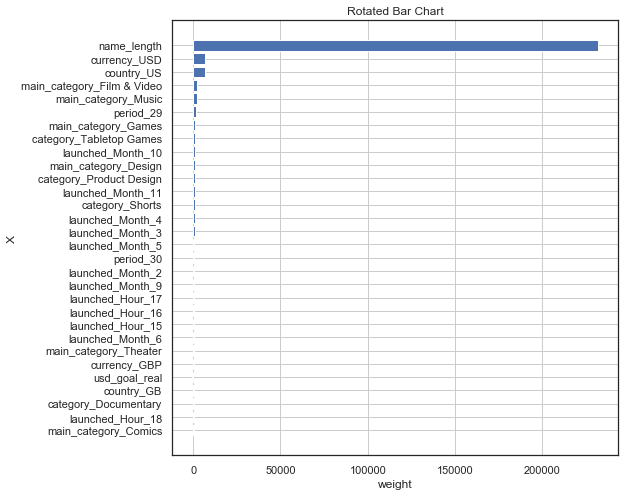

In [201]:
# ****************************************************************************
# ◆ 3.モデル作成
# ****************************************************************************
X = df_dummies.drop('state', axis=1).values # 説明変数
y = df_dummies['state'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をリストへ変換
list_f = list(df_dummies.drop('state', axis=1).columns)
list_w = np.reshape(clf.coef_[0], -1).tolist()

# ------------------------------------------------
# 3-1.重みを表示  
# ------------------------------------------------
list_df = pd.DataFrame(columns=['feature','weight','abs_w'])
for i, feature in enumerate(list_f):
    #print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, list_w[i]))
    list_df = list_df.append( pd.Series([feature,list_w[i],abs(list_w[i])],index=list_df.columns), ignore_index=True)

# 絶対値の降順ソートトップ30
print('\n▼ 回帰係数を表示（絶対値の降順：Top30）')
list_df = list_df.sort_values('abs_w', ascending=False)
list_df.reset_index(drop=True,inplace=True)
list_df = list_df.drop('abs_w', axis=1)
list_head = list_df.head(30)
print(list_head)

# 重みの大きさをグラフで表示
plt.figure(figsize=(8, 8))
plt.barh(np.arange(len(list_head['feature']))[::-1], list_head['weight'], align='center')
plt.yticks(np.arange(len(list_head['feature']))[::-1], list_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()


In [195]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************

# ラベルを予測
y_est = clf.predict(X)

print('\n▼ モデルの予測結果(先頭10件)')
print(y_est[:11])

# 予測確率を出力
print('\n▼ 結果の予測確率(先頭10件)')
p = clf.predict_proba(X)
print('p(失敗する確率：成功する確率):\n',p[:11].astype(float))

print('\n▼ モデルの評価結果')

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])

conf_mat


▼ モデルの予測結果(先頭10件)
[1 0 0 1 0 1 0 1 0 1 0]

▼ 結果の予測確率(先頭10件)
p(失敗する確率：成功する確率):
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]

▼ モデルの評価結果
対数尤度 = -14.931
正答率 = 56.772%
適合率（Precision※精度) = 73.061%
再現率（Recall※検出率) = 43.540%
F1値（F1-score） = 54.563%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,86086,111633
正解 = 資金調達成功,31742,102214


### 気になること
- countryに含まれるN,0"について、そのまま利用して良かったのか。
- 数値項目でない項目同士の相関関係をみる方法はあるか。例）main_categoryとcategory
- 重みのプラスとマイナスについて、それぞれに意味はあるのか。
- 目標金額の外れ値について、そのまま利用して良かったのか。